***Projeto Segmenta.AI***

- Imports

In [2]:
import cx_Oracle
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy import stats as st 
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

- Conexão Oracle

In [ ]:
username = 'XXXXXXXXXXXXX'
password = 'XXXXXXXXXXXXX'
dsn = 'XXXXXXXXXXXXXXXXXXXX' 
connection = cx_Oracle.connect(username, password, dsn)

- Querys

Abaixo, são consultadas as tabelas NECESSÁRIAS PARA A MODELAGEM.
Vale ressaltar que temos outras tabelas em nosso banco, mas somente são usadas no Dashboard, e não na construção do modelo.

In [4]:
#Tabela de Clientes
query_tb_clientes = "SELECT * FROM tb_clientes"
df_tb_clientes = pd.read_sql(query_tb_clientes, con=connection)

C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\3256300317.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tb_clientes = pd.read_sql(query_tb_clientes, con=connection)


In [5]:
#Tabela de Contratos
query_tb_contratos = "SELECT * FROM tb_contratos"
df_tb_contratos = pd.read_sql(query_tb_contratos, con=connection)

C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\3149067922.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tb_contratos = pd.read_sql(query_tb_contratos, con=connection)


In [24]:
#Tabela de Transações
query_tb_transacoes = "SELECT * FROM tb_transacoes"
df_tb_transacoes = pd.read_sql(query_tb_transacoes, con=connection)

C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\40016002.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tb_transacoes = pd.read_sql(query_tb_transacoes, con=connection)


In [8]:
#Tabela de Tickets Suporte
query_tb_ticket = "SELECT * FROM tb_ticket"
df_tb_ticket = pd.read_sql(query_tb_ticket, con=connection)

C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\276207096.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tb_ticket = pd.read_sql(query_tb_ticket, con=connection)


- Pré-Processamento e Transformações

In [9]:
#1. Missings
#Realizado para cada DF, mas deixamos um default
missings_por_coluna = df_tb_transacoes.isna().sum()

missings_por_coluna = pd.DataFrame(missings_por_coluna, 
                                   columns=['n']) \
                                   .reset_index() \
                                   .rename(columns={'index': 'variaveis'}
                                   )

missings_por_coluna

,variaveis,n
0,id_proposta,0
1,id_item_proposta,0
2,dt_upload,0
3,ds_hospedagem,0
4,cd_cliente,0
5,cd_prod,0
6,qt_solicitada,0
7,meses_bonificacao,0
8,vl_pct_desc_temp,0
9,vl_pct_desc,0


In [10]:
#2. Outliers
df_tb_transacoes['vl_total'] = pd.to_numeric(df_tb_transacoes['vl_total'].str.replace(',', '.'), errors='coerce')
df_tb_transacoes['valor_z'] = scale(df_tb_transacoes['vl_total']).astype(float)
df_tb_transacoes

,id_proposta,id_item_proposta,dt_upload,ds_hospedagem,cd_cliente,cd_prod,qt_solicitada,meses_bonificacao,vl_pct_desc_temp,vl_pct_desc,vl_preco_unitario,vl_desc_temp,vl_total,vl_cheio,vl_desconto,valor_z
0,AAMQSF,1,2025-03-25,ON PREMISES,TFDPFE,0113301112,1,0,0,"28,6492879623732","2101,92868395988",0,2101.928684,"6599,31618873727","4497,38750477739",-0.058177
1,AAJUVA,7,2024-03-28,ON PREMISES,T03306,AUT.04.000450,1,0,0,0,"0,53388988572581",0,0.533890,"0,53388988572581",0,-0.119205
2,AAKX71,1,2024-08-21,ON PREMISES,T48463,1M13301050,1,0,0,0,"1222,89790447049",0,1222.897904,"63,0578605187964",0,-0.083705
3,AAMJNP,1,2025-02-17,ON PREMISES,TFEED1,71A3301148,1,0,0,0,"60,1067526465167",0,60.106753,"60,1067526465167",0,-0.117475
4,AAKFC4,1,2024-05-23,ON PREMISES,TDC1GA,CONSV.502,"4,5",0,0,0,"93,9520083156387",0,422.786139,"0,0189173581556389",0,-0.106942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22735,AAKGKI,2,2024-06-18,ON PREMISES,T75385,0119017000-8,15,0,0,"6,30578605187964","1084,97354808641",0,16274.603221,"19146,6365364853","2872,0333151891",0.353422
22736,AAKU65,2,2024-08-30,ON PREMISES,TFDSD7,71A3301148,1,999,"9,6305748055937",0,"47,1925028122672","10,8123211502896",47.192503,"61,2165709916475",0,-0.117850
22737,AAKYPU,1,2024-08-29,ON PREMISES,TFDVJZ,BMV.983,1,0,0,"40,3233998730863","537,824696222182",0,537.824696,"13189,451152983","12651,6264567608",-0.103601
22738,AAMEQU,1,2025-01-23,ON PREMISES,T57702,103600011-7,1,0,0,0,"4140,77428425676",0,4140.774284,"4140,77428425676",0,0.001035


In [11]:
df_tb_contratos['valor_total_contrato'] = pd.to_numeric(df_tb_contratos['valor_total_contrato'].str.replace(',', '.'), errors='coerce')
df_tb_contratos['valor_z'] = scale(df_tb_contratos['valor_total_contrato']).astype(float)
df_tb_contratos

,cd_cliente,produto,linha_receita,marca_totvs,modalidade_comercial,periodicidade,situacao_contrato,valor_total_contrato,data_assinatura_contrato,valor_z
0,TFDHYB,LICENCA CNPJ VAREJO WT,CDU TOTVS SERIE T,DISTRIBUICAO & VAREJO - CORE,MODALIDADE TRADICIONAL,00 - Mensal,ATIVO,2121.354709,2023-01-13,-0.007346
1,TFEBO2,T. CLOUD WINTHOR SOB PROJETO,CLOUD COMPUTING.,DISTRIBUICAO & VAREJO - CORE,MODALIDADE SERVICOS RECORRENTES,00 - Mensal,ATIVO,523.123807,2024-09-30,-0.019102
2,TFCSI9,IAAS-IP PUBLICO-M,CLOUD COMPUTING.,CLOUD,MODALIDADE SERVICOS RECORRENTES,00 - Mensal,CANCELADO,2.547538,2023-07-06,-0.022932
3,TFCWZO,SAAS VA SALES,SAAS SERIE T,DISTRIBUICAO & VAREJO - CORE,MODALIDADE ASSINATURA COMPLEMENTAR,00 - Mensal,ATIVO,103.902539,2021-06-23,-0.022186
4,TFDDIF,INTERA RH COMPLETO,SAAS INTERA SOFTWARE,RH - CORE,MODALIDADE ASSINATURA (INTERA),00 - Mensal,TROCADO,461.835770,2022-06-27,-0.019553
...,...,...,...,...,...,...,...,...,...,...
238592,TFBXYW,ASSINATURA MENSAL INTERNET CMN,SERVICOS CMNET RESERVAS,HOSPITALIDADE - CORE,MODALIDADE SERVICOS RECORRENTES,00 - Mensal,CANCELADO,149.043559,2012-05-30,-0.021854
238593,TFCHXY,SMS USUARIO VENDEDOR,SMS TOTVS SERIE T,DISTRIBUICAO & VAREJO - CORE,MODALIDADE TRADICIONAL,00 - Mensal,ATIVO,85.851175,2020-11-11,-0.022319
238594,TFDA63,ALMOXARIFADO E ESTOQUE,SAAS CMNET HOTAL,HOSPITALIDADE - CORE,MODALIDADE ASSINATURA COMPLEMENTAR,00 - Mensal,ATIVO,246.270372,2019-03-26,-0.021139
238595,TFDVH0,TEF TOTVS CLOUD PDV PRINCIPAL,SAAS TEF,DISTRIBUICAO & VAREJO - CORE,MODALIDADE ASSINATURA COMPLEMENTAR,00 - Mensal,CANCELADO,47.192503,2024-08-21,-0.022603


In [12]:
#Verificar a normalização do dado, com média próxima de 0 e desvio próximo de 1
df_tb_transacoes[['vl_total', 'valor_z']].describe()

,vl_total,valor_z
count,2.274000e+04,2.274000e+04
mean,4.105135e+03,1.249855e-17
std,3.443398e+04,1.000022e+00
min,4.203857e-03,-1.192200e-01
25%,1.117059e+02,-1.159760e-01
50%,5.187833e+02,-1.041538e-01
75%,2.352753e+03,-5.089218e-02
max,3.573279e+06,1.036549e+02


In [13]:
df_tb_contratos[['valor_total_contrato', 'valor_z']].describe()

,valor_total_contrato,valor_z
count,2.385970e+05,2.385970e+05
mean,3.120108e+03,-7.147209e-19
std,1.359503e+05,1.000002e+00
min,-1.303196e-01,-2.295136e-02
25%,5.212783e+00,-2.291206e-02
50%,1.773019e+02,-2.164624e-02
75%,1.050964e+03,-1.521988e-02
max,3.558788e+07,2.617489e+02


In [14]:
#Tratamento
wins_values = df_tb_contratos['valor_total_contrato'].quantile([0.05, 0.90]).to_list()

df_tb_contratos['valor_wins'] = df_tb_contratos['valor_total_contrato'].clip(wins_values[0], wins_values[1])

<Axes: >

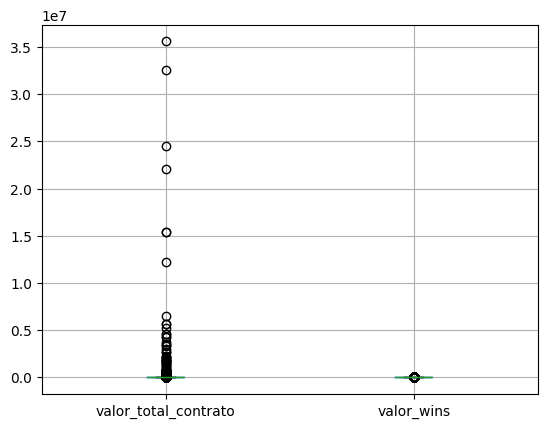

In [15]:
df_tb_contratos[['valor_total_contrato', 'valor_wins']].boxplot()

- Modelagem

Testamos dois modelos em nossas análises, mas escolhemos seguir com o K-Means. Para documentação organizada, abaixo demonstramos o modelo escolhido.

In [ ]:
RANDOM_STATE = 42

#1. Limpezas e Transformações
def _to_datetime(series, dayfirst=True):
    """Converte para datetime com coerce e dayfirst=True por padrão."""
    return pd.to_datetime(series, errors='coerce', dayfirst=dayfirst)

def _to_numeric(series):
    """Converte strings monetárias para float (coerce)."""
    s = series.astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    return pd.to_numeric(s, errors='coerce')

#2. Construção das features
def construir_features(
    df_tb_clientes: pd.DataFrame,
    df_tb_contratos: pd.DataFrame,
    df_tb_ticket: pd.DataFrame,  
    col_id='cd_cliente',
    data_base: pd.Timestamp | None = None
) -> pd.DataFrame:
    dfc = df_tb_clientes.copy()
    dft = df_tb_contratos.copy()
    dftk = df_tb_ticket.copy()  

    # --- normalizações existentes ---
    dfc['dt_abertura'] = _to_datetime(dfc['dt_abertura'])
    dft['data_assinatura_contrato'] = _to_datetime(dft['data_assinatura_contrato'])
    dftk['dt_criacao'] = _to_datetime(dftk['dt_criacao'])  

    if not np.issubdtype(dft['valor_total_contrato'].dtype, np.number):
        dft['valor_total_contrato'] = _to_numeric(dft['valor_total_contrato'])

    # Periodicidade → meses
    period_map = {
        '00 - Mensal': 1,
        '01 - Bimestral': 2,
        '02 - Trimestral': 3,
        '03 - Quadrimestral': 4,
        '05 - Semestral': 6,
        '11 - Anual': 12,
        '-': np.nan
    }
    dft['period_meses'] = dft['periodicidade'].map(period_map)

    # --- data_base ---
    if data_base is None:
        candidates = [pd.Timestamp.today().normalize()]
        if dft['data_assinatura_contrato'].notna().any():
            candidates.append(dft['data_assinatura_contrato'].max().normalize())
        if dfc['dt_abertura'].notna().any():
            candidates.append(dfc['dt_abertura'].max().normalize())
        if dftk['dt_criacao'].notna().any():
            candidates.append(dftk['dt_criacao'].max().normalize()) 
        data_base = max(candidates)

    # --- janela 12 meses contratos ---
    inicio_12m = data_base - relativedelta(months=12)
    contratos_12m = dft[
        (dft['data_assinatura_contrato'] >= inicio_12m) &
        (dft['data_assinatura_contrato'] <= data_base)
    ]

    # --- agregações 12m contratos ---
    agg_12m = contratos_12m.groupby(col_id).agg(
        qt_contratos_12m=('data_assinatura_contrato', 'count'),
        valor_contratado_12m=('valor_total_contrato', 'sum'),
        produtos_distintos_12m=('produto', pd.Series.nunique),
        periodicidade_max_meses_12m=('period_meses', 'max')
    ).reset_index()
    agg_12m['fechou_>=1ano_12m'] = agg_12m['periodicidade_max_meses_12m'].fillna(0) >= 12
    agg_12m['multi_produto_12m'] = agg_12m['produtos_distintos_12m'].fillna(0) > 1

    # --- agregações lifetime ---
    agg_total = dft.groupby(col_id).agg(
        produtos_distintos_total=('produto', pd.Series.nunique),
        periodicidade_max_meses_total=('period_meses', 'max')
    ).reset_index()
    agg_total['fechou_>=1ano_total'] = agg_total['periodicidade_max_meses_total'].fillna(0) >= 12
    agg_total['multi_produto_total'] = agg_total['produtos_distintos_total'].fillna(0) > 1

    # --- base clientes + tempo de vida ---
    base = dfc[[col_id, 'dt_abertura', 'vl_faixa_faturamento']].copy()
    base['tempo_vida_dias'] = (data_base - base['dt_abertura']).dt.days
    base['tempo_vida_anos'] = base['tempo_vida_dias'] / 365.25

    # --- nova variável: média de tickets por mês ---
    tickets_12m = dftk[
        (dftk['dt_criacao'] >= inicio_12m) &
        (dftk['dt_criacao'] <= data_base)
    ]
    agg_tickets = tickets_12m.groupby(col_id).agg(
        qt_tickets_12m=('dt_criacao', 'count')
    ).reset_index()
    # calcular média por mês (12 meses)
    agg_tickets['ticket_medio_por_mes'] = agg_tickets['qt_tickets_12m'] / 12

    # --- mergear tudo ---
    feats = (base
             .merge(agg_12m, on=col_id, how='left')
             .merge(agg_total[[col_id, 'fechou_>=1ano_total', 'multi_produto_total']], on=col_id, how='left')
             .merge(agg_tickets[[col_id, 'ticket_medio_por_mes']], on=col_id, how='left'))  

    # --- preenchimentos ---
    fill_zero = ['qt_contratos_12m', 'valor_contratado_12m', 'produtos_distintos_12m', 'periodicidade_max_meses_12m', 'ticket_medio_por_mes']
    for c in fill_zero:
        if c in feats.columns:
            feats[c] = feats[c].fillna(0)

    fill_false = ['fechou_>=1ano_12m','multi_produto_12m','fechou_>=1ano_total','multi_produto_total']
    for c in fill_false:
        if c in feats.columns:
            feats[c] = feats[c].fillna(False)

    feats = feats[feats['tempo_vida_dias'].notna()].copy()
    feats['data_base'] = data_base

    return feats

#3. Pré-Processamento e Transformações
def treinar_clusters(feats: pd.DataFrame, col_id='cd_cliente'):
    numeric_features = [
        'tempo_vida_anos',
        'qt_contratos_12m',
        'valor_contratado_12m',
        'produtos_distintos_12m',
        'periodicidade_max_meses_12m',
        'fechou_>=1ano_12m',
        'multi_produto_total'
    ]

    for c in ['fechou_>=1ano_12m', 'multi_produto_total']:
        if feats[c].dtype == bool:
            feats[c] = feats[c].astype(int)

    categorical_features = ['vl_faixa_faturamento']
    X = feats[numeric_features + categorical_features].copy()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imp', SimpleImputer(strategy='median')),
                ('pow', PowerTransformer(method='yeo-johnson')), 
                ('sc', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline(steps=[
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('oh', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ],
        remainder='drop'
    )

    Z = preprocessor.fit_transform(X)

    resultados_kmeans = []
    melhor = {'k': None, 'sil': -1, 'db': np.inf, 'ch': -1, 'modelo': None, 'labels': None}
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
        labels = km.fit_predict(Z)
        sil = silhouette_score(Z, labels)
        db = davies_bouldin_score(Z, labels)
        ch = calinski_harabasz_score(Z, labels)
        resultados_kmeans.append({'k': k, 'silhouette': sil, 'davies_bouldin': db, 'calinski_harabasz': ch})
        if sil > melhor['sil'] or (sil == melhor['sil'] and db < melhor['db']):
            melhor.update({'k': k, 'sil': sil, 'db': db, 'ch': ch, 'modelo': km, 'labels': labels})

    resultados_gmm = []
    melhor_gmm = {'k': None, 'bic': np.inf, 'modelo': None, 'labels': None}
    for k in range(2, 10):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
        gmm.fit(Z)
        bic = gmm.bic(Z)
        resultados_gmm.append({'k': k, 'bic': bic})
        if bic < melhor_gmm['bic']:
            melhor_gmm.update({'k': k, 'bic': bic, 'modelo': gmm, 'labels': gmm.predict(Z)})

    usar_gmm = melhor['sil'] < 0.20
    final_model = melhor_gmm['modelo'] if usar_gmm else melhor['modelo']
    final_labels = melhor_gmm['labels'] if usar_gmm else melhor['labels']
    final_alg = 'GMM' if usar_gmm else 'KMeans'
    final_k = melhor_gmm['k'] if usar_gmm else melhor['k']

    saida = feats[[col_id]].copy()
    saida['cluster'] = final_labels

    perfil = (feats
          .join(saida.set_index(col_id), on=col_id)
          .groupby('cluster')
          .agg(
              clientes=('cluster', 'size'),
              tempo_vida_anos_median=('tempo_vida_anos', 'median'),
              qt_contratos_12m_median=('qt_contratos_12m', 'median'),
              valor_contratado_12m_median=('valor_contratado_12m', 'median'),
              produtos_distintos_12m_median=('produtos_distintos_12m', 'median'),
              periodicidade_max_meses_12m_max=('periodicidade_max_meses_12m', 'max'),
              **{'pct_fechou_>=1ano_12m': ('fechou_>=1ano_12m', lambda s: 100 * s.mean())},
              **{'pct_multi_produto_total': ('multi_produto_total', lambda s: 100 * s.mean())}
          )
          .sort_values('clientes', ascending=False)
          .reset_index())

    return {
        'preprocessor': preprocessor,
        'algoritmo': final_alg,
        'k': final_k,
        'modelo': final_model,
        'labels': final_labels,
        'perfil_clusters': perfil,
        'metricas_kmeans': pd.DataFrame(resultados_kmeans),
        'metricas_gmm': pd.DataFrame(resultados_gmm)
    }

#4. Análise do resultado (exportando)
def exportar_resultados(feats, resultado, col_id='cd_cliente',
                        nome_base='clientes_clusterizados'):
    df_final = feats.copy()
    df_final['cluster'] = resultado['labels']

    df_final.to_csv(f"{nome_base}.csv", sep=';', index=False, encoding='utf-8')
    df_final.to_excel(f"{nome_base}.xlsx", index=False)
    resultado['perfil_clusters'].to_csv(f"{nome_base}_perfil.csv", sep=';', index=False, encoding='utf-8')
    resultado['perfil_clusters'].to_excel(f"{nome_base}_perfil.xlsx", index=False)

    print("Arquivos gerados:")
    print(f" - {nome_base}.csv")
    print(f" - {nome_base}.xlsx")
    print(f" - {nome_base}_perfil.csv")
    print(f" - {nome_base}_perfil.xlsx")

    return df_final

def plot_clusters_pca(feats, resultado, col_id='cd_cliente'):
    numeric_features = [
        'tempo_vida_anos',
        'qt_contratos_12m',
        'valor_contratado_12m',
        'produtos_distintos_12m',
        'periodicidade_max_meses_12m',
        'fechou_>=1ano_12m',
        'multi_produto_total'
    ]
    categorical_features = ['vl_faixa_faturamento']

    X = feats[numeric_features + categorical_features].copy()
    for c in ['fechou_>=1ano_12m', 'multi_produto_total']:
        if X[c].dtype == bool:
            X[c] = X[c].astype(int)

    Z = resultado['preprocessor'].transform(X)

    pca = PCA(n_components=2, random_state=42)
    Z2D = pca.fit_transform(Z)

    labels = resultado['labels']
    alg = resultado['algoritmo']
    k = resultado['k']

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(Z2D[:, 0], Z2D[:, 1], c=labels, cmap='tab10', s=60, alpha=0.7, edgecolors='k')
    plt.title(f"Clusters de Clientes ({alg}, K={k}) - PCA 2D", fontsize=14)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    handles, _ = scatter.legend_elements()
    plt.legend(handles, [f"Cluster {i}" for i in range(k)], title="Clusters")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\4156775160.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(series, errors='coerce', dayfirst=dayfirst)
C:\Users\sepve\AppData\Local\Temp\ipykernel_11128\4156775160.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats[c] = feats[c].fillna(False)


Arquivos gerados:
 - clientes_clusterizados.csv
 - clientes_clusterizados.xlsx
 - clientes_clusterizados_perfil.csv
 - clientes_clusterizados_perfil.xlsx


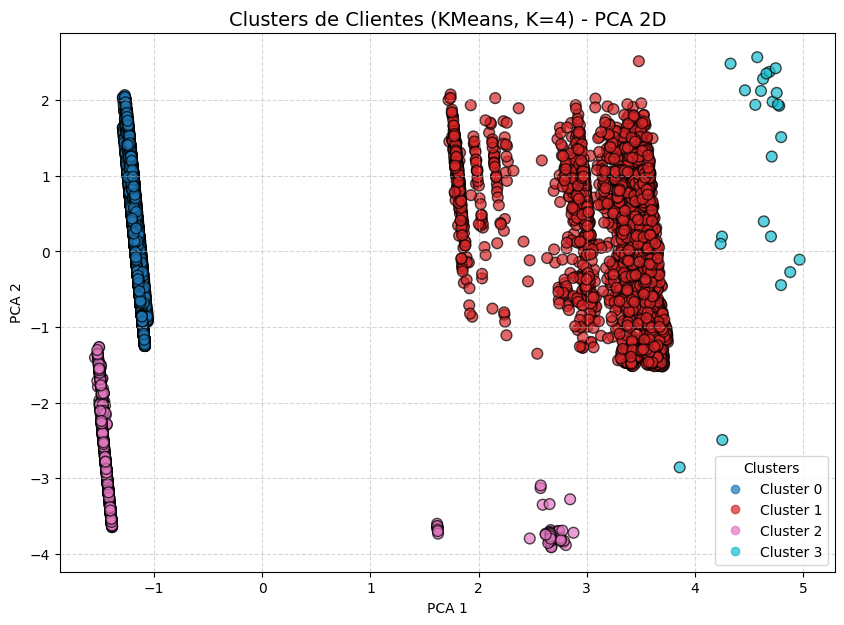

In [ ]:
#lower nas colunas
df_tb_clientes.columns = df_tb_clientes.columns.str.lower()
df_tb_contratos.columns = df_tb_contratos.columns.str.lower()
df_tb_ticket.columns = df_tb_ticket.columns.str.lower()

#dataset de features
feats = construir_features(df_tb_clientes, df_tb_contratos, df_tb_ticket, col_id='cd_cliente')

#clusterização
resultado = treinar_clusters(feats, col_id='cd_cliente')

df_final = exportar_resultados(feats, resultado, col_id='cd_cliente', nome_base='clientes_clusterizados')

plot_clusters_pca(feats, resultado, col_id='cd_cliente')